<a name='1'></a>
## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent. This helps to grade your work.


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import time


import numpy as np
import math
import igraph as ig

from vertexmodelpy.basic_topology import *

from vertexmodelpy.triangulation import Triangulation
from vertexmodelpy.minimizer import TissueMinimizer
from vertexmodelpy.energetics import tissue_energy,tissue_gradient
from vertexmodelpy.topology_triggers import resolve_high_order_vertices

from vertexmodelpy.utilities import find_face_vertices_faster,get_face_colors
from vertexmodelpy.tissue_generation import convert_to_tissue_class,generate_hexagonal_disk

from vertexmodelpy.coarse_graining_functions import *


from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import PolyCollection,LineCollection


<a name='1-1'></a>
### 1.1 - Load the Data and Split the Data into Train/Test Sets

You'll be using the Happy House dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!  

In [32]:
# t0 = time.time()
# pid = os.getpid()

# seed = (int(t0) & 0xFFFF) | pid << 16

seed = 12345
rng = np.random.default_rng(seed)

In [4]:
def find_dual_graph(tissue):
    tissue_dual_triangulation = Triangulation(tissue,triangulation_type='dual_triangulation')
    num_of_vertices = len(tissue_dual_triangulation.vert_df)

    graph_edge_list = tissue_dual_triangulation.edge_df[['v_out_id','v_in_id']].values
    graph_edge_list = np.unique(np.sort(graph_edge_list),axis=0)
    
    g = ig.Graph(n=num_of_vertices,edges=graph_edge_list,directed=False)

    g.vs['id'] = range(len(g.vs))
    
    g.vs['x'] = tissue_dual_triangulation.vert_df['x'].values
    g.vs['y'] = tissue_dual_triangulation.vert_df['y'].values
    
    return g

def find_closest_cell(tissue,centroids,angle_list,radii_fraction = []):
    
    tot_area = tissue.face_df['area'].sum()
    tissue_radius = math.sqrt(tot_area/pi)

    cos_angs, sin_angs = np.cos(angle_list), np.sin(angle_list)
    
    if radii_fraction == []:
       radii_fraction = np.full(len(angle_list),0.5) 

    prefered_centers = [frac*tissue_radius*np.array([cos_phi, sin_phi])
                        for frac, cos_phi, sin_phi in zip(radii_fraction,cos_angs, sin_angs)]

    center_cell_ids = [np.argmin(np.linalg.norm(centroids - pos,axis=1)) for pos in prefered_centers] 

    return center_cell_ids

def preprocess_tissue(tissue,smooth_boundary=False):
    quasi_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient)
    quasi_solver.find_energy_min()

    resolve_high_order_vertices(tissue)

    if smooth_boundary == True:
        round_off_boundary(tissue)

    quasi_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient)
    quasi_solver.find_energy_min()
    
    return tissue

In [33]:
N_disk = 50

tissue_original = convert_to_tissue_class(generate_hexagonal_disk,N_disk)
tissue_original = preprocess_tissue(tissue_original,smooth_boundary=True)

#defining parameters

number_of_cells = len(tissue_original.face_df)
gtol = 2*len(tissue_original.vert_df)*1e-6


print(f'Number of cells: {number_of_cells}')

Number of cells: 173


In [167]:
b=np.array([1.2])
b

array([1.2])

In [169]:
float(b)

1.2

In [34]:
tissue = deepcopy(tissue_original)

In [94]:
# tissue.vert_df[['x','y']].apply(min)
x_y_min_max = tissue.vert_df[['x','y']].apply(lambda df: [df.min(),df.max()]).values.transpose()
xmin,xmax = x_y_min_max[0]
ymin,ymax = x_y_min_max[1]


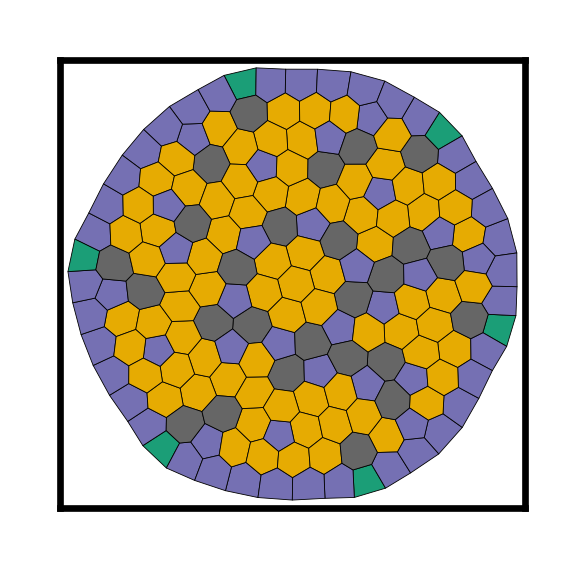

In [165]:
poly_verts = find_face_vertices_faster(tissue,tissue.face_dbonds)
# poly_verts_triang = find_face_vertices_faster(tissue_triangulation,tissue_triangulation.face_dbonds)

# facecolors = get_face_colors(tissue,color_by='num_sides')
facecolors = get_face_colors(tissue,color_by='num_sides',color_map=cm.Dark2)
fig, ax = plt.subplots(1, frameon = True, dpi=600,figsize=(1.,1.))
ax.set_aspect('equal')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# ax.set_frame_on(False)

# Make the collection and add it to the plot.

coll = PolyCollection(poly_verts, edgecolors='black',facecolors=facecolors,linewidths=0.1)


ax.add_collection(coll)

plot_margin = 0.2


x0, x1, y0, y1 = plt.axis()
plt.axis((xmin - plot_margin,
          xmax + plot_margin,
          ymin - plot_margin,
          ymax + plot_margin))

plt.show()

In [9]:
g = find_dual_graph(tissue)

In [10]:
cell_centroids = tissue.face_df[['x','y']].values
centroid_cell_id = np.argmin(np.linalg.norm(cell_centroids - np.mean(cell_centroids),axis=1))

tissue.vert_df[['x','y']] -= cell_centroids[centroid_cell_id]
tissue.update_tissue_geometry()

cell_centroids = tissue.face_df[['x','y']].values

# center_cell_ids = [centroid_cell_id]

In [11]:
num_centers = 3
# angle_list = np.array([i*2*pi/num_centers for i in range(num_centers)])

# radii_fraction = np.full(num_centers,0.4)

angle_list = np.array([pi/2, pi/2 + 2*pi/3, pi/2 + 2*2*pi/3])
center_cell_ids = find_closest_cell(tissue,cell_centroids,angle_list)



# angle_list = np.array([pi/4, 3*pi/4, 5*pi/4, 7*pi/4])
# radii_fraction = [0.4 for i in range(num_centers)]

# center_cell_ids = find_closest_cell(tissue,cell_centroids,angle_list,radii_fraction = radii_fraction)

In [12]:
neighbor_list = [g.neighborhood(cell_id, order=4) for cell_id in center_cell_ids]

# neighbor_list_centroid = [g.neighborhood(cell_id, order=4) for cell_id in [centroid_cell_id]]

# neighbor_list += neighbor_list_centroid

In [13]:
len(neighbor_list)

3

IndexError: index 369 is out of bounds for axis 0 with size 173

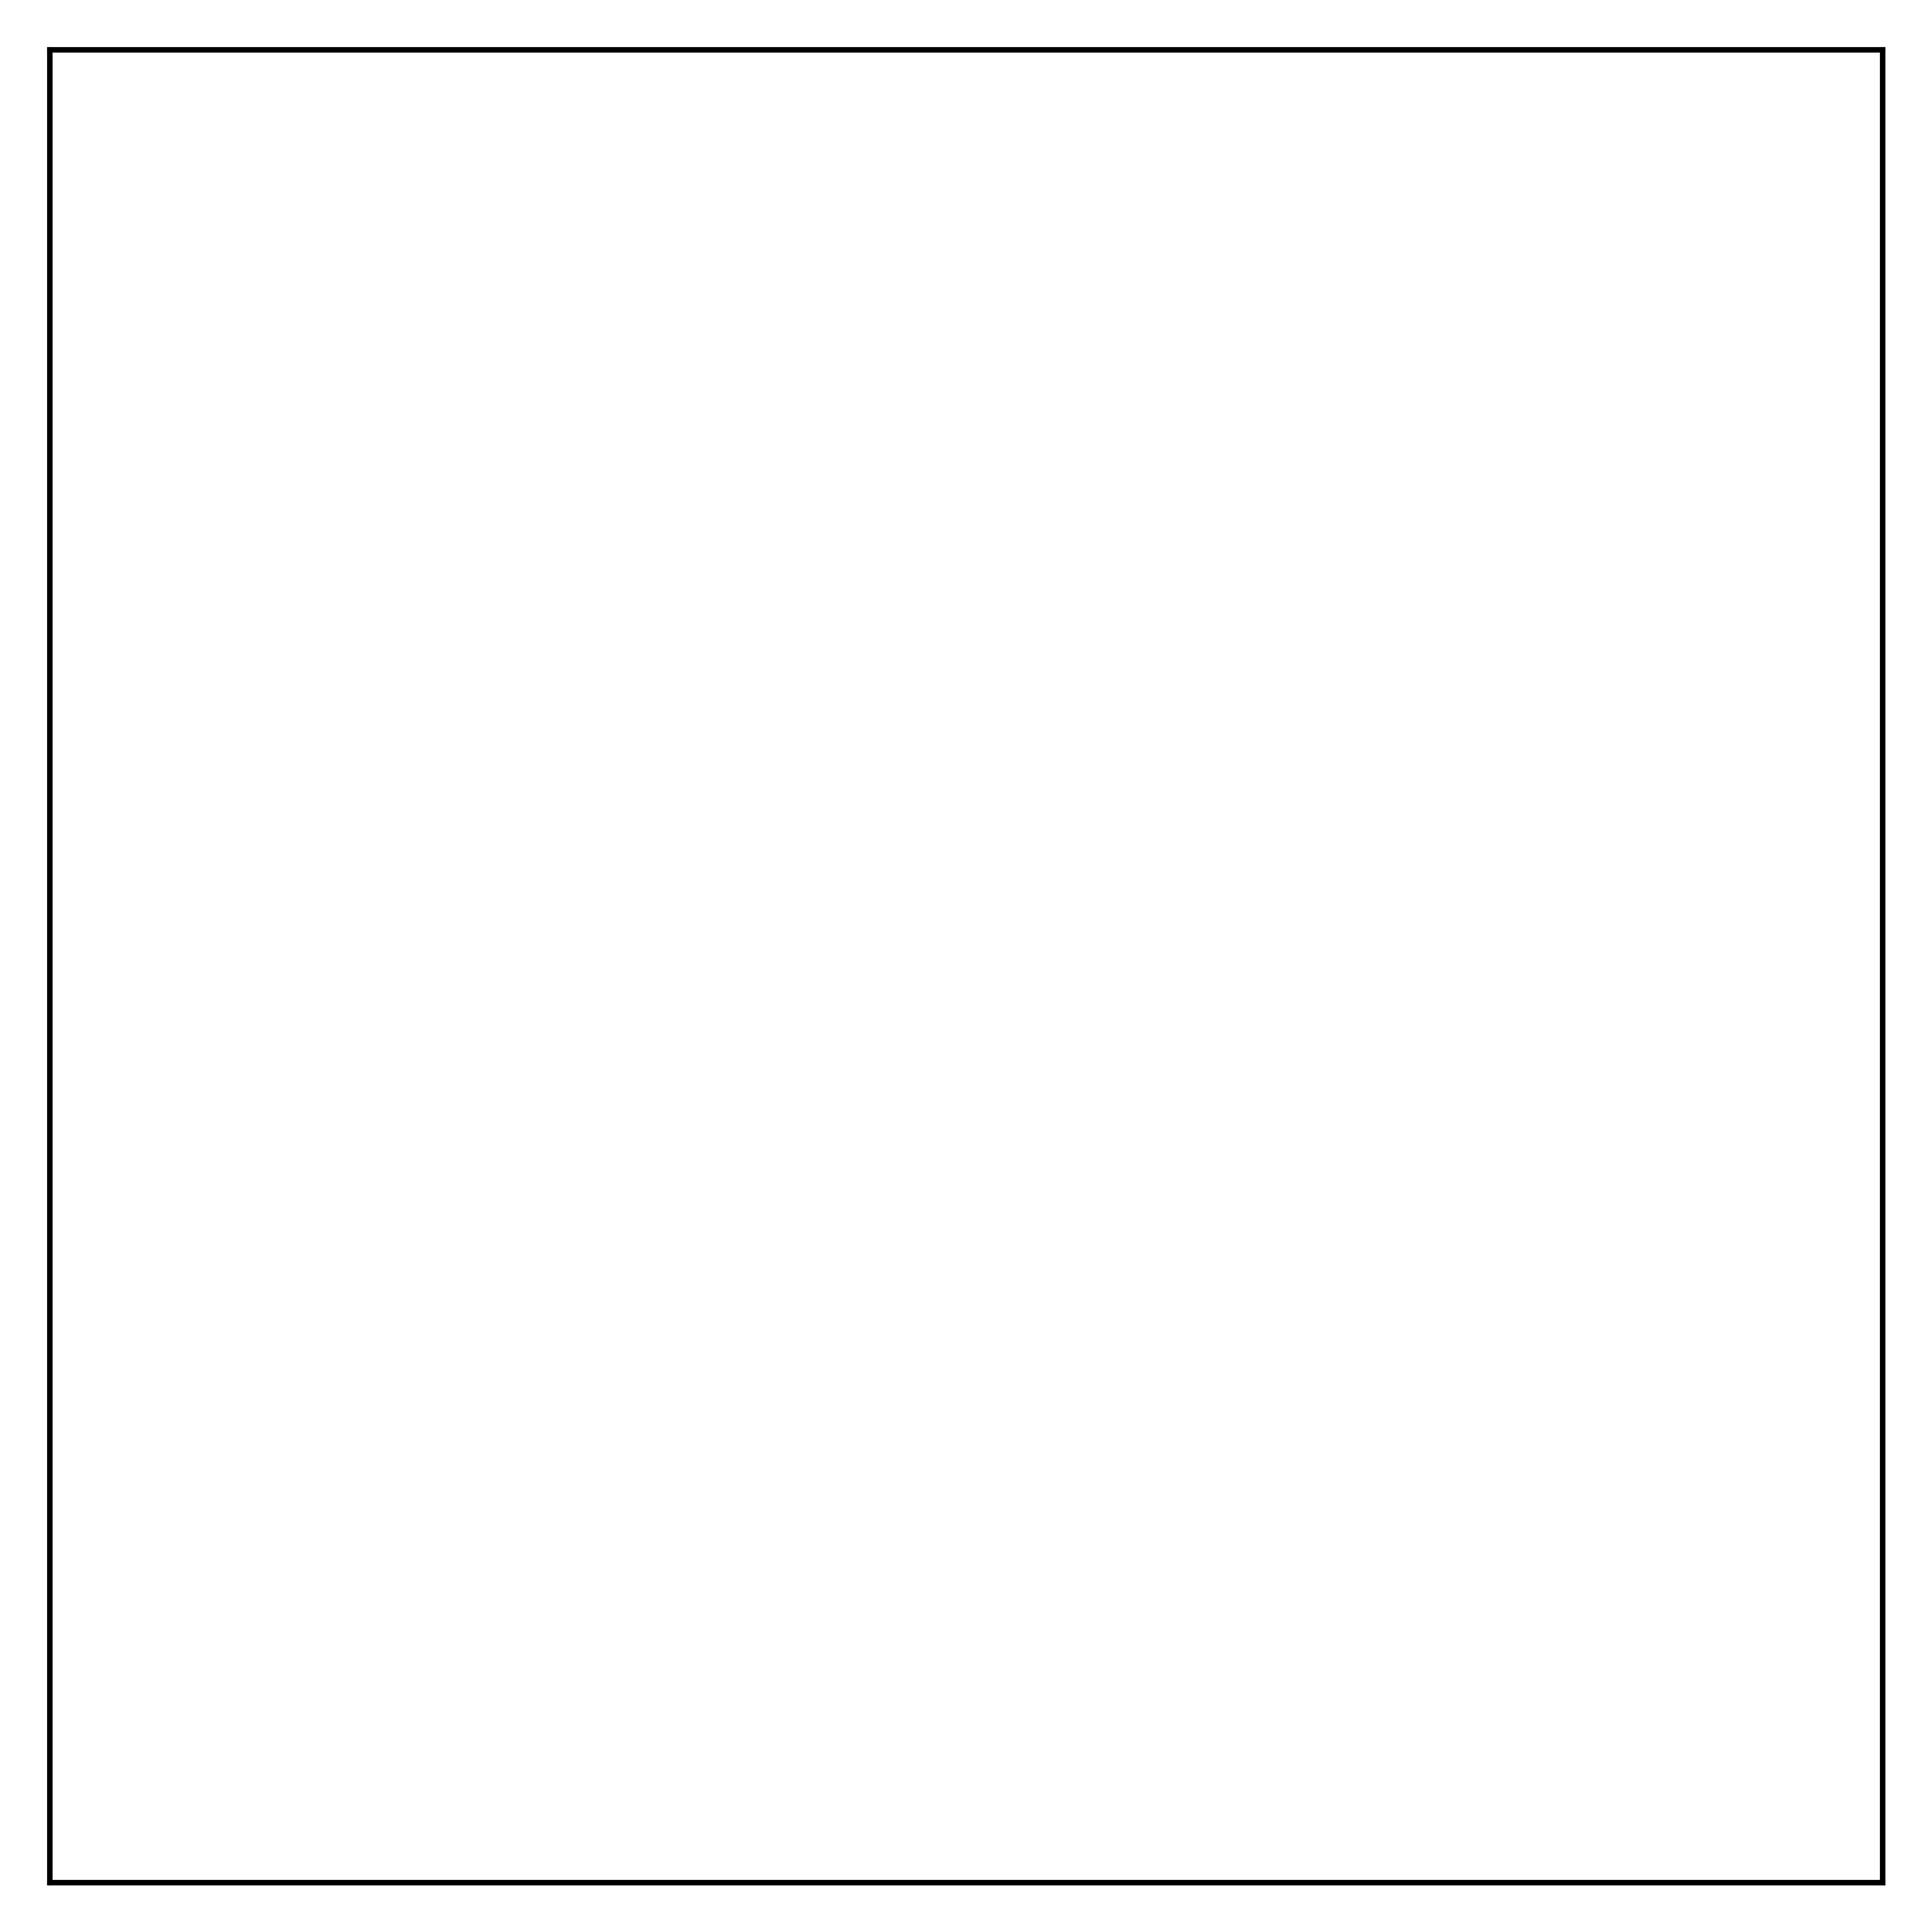

In [37]:
poly_verts = find_face_vertices_faster(tissue,tissue.face_dbonds)
# poly_verts_triang = find_face_vertices_faster(tissue_dual_triangulation,tissue_dual_triangulation.face_dbonds)


# facecolors = get_face_colors(tissue,color_by='num_sides')
fig, ax = plt.subplots(nrows = 1, ncols = 1, frameon = True, dpi=1000)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_frame_on(False)

# Make the collection and add it to the plot.

coll = PolyCollection(poly_verts, edgecolors='black',facecolors='mediumpurple',linewidths=0.1,zorder=1)

for neighbors in neighbor_list:
    coll2 = PolyCollection(poly_verts[neighbors], edgecolors='black',facecolors='purple',linewidths=0.1,zorder=2)
    ax.add_collection(coll2)
    

# for neighbors in ordered_contours_per_patch:
#     coll4 = PolyCollection(poly_verts[neighbors], edgecolors='black',facecolors='salmon',linewidths=0.1,zorder=4)
#     ax.add_collection(coll4)
 
# node_coords = np.dstack((g.vs['x'], g.vs['y']))[0]   

# for neighbors in ordered_contours_per_patch:
#     # face_pairs = list(zip(neighbors[0],np.roll(neighbors[0],-1)))
#     face_pairs = zip(neighbors,np.roll(neighbors,-1))

    
#     for f_pair in face_pairs:

#         start_coords = node_coords[f_pair[0]]
#         end_coords = node_coords[f_pair[1]]

#         dr = 0.9*(end_coords - start_coords)
        
#         plt.arrow(start_coords[0], start_coords[1], dr[0], dr[1],
#                 head_width=0.3, head_length=0.1, linewidth=0.15, color='magenta', length_includes_head=True,zorder=5)
        
    
    # coll4 = PolyCollection(poly_verts[neighbors], edgecolors='black',facecolors='salmon',linewidths=0.1,zorder=4)
    # ax.add_collection(coll4)
    
# lc = LineCollection(elong_lines_per_cell, colors='white', linewidths=0.1,zorder=4)

# ax.add_collection(lc)


ax.add_collection(coll)
# ax.add_collection(coll3)


ax.autoscale_view()


side_size = 1.0
fig.set_size_inches(side_size, side_size)

# plt.clf()
plt.tight_layout()
plt.box(on=None)
plt.show()

# fig.savefig('filename4.png',  transparent=True)

In [15]:
initial_areas = tissue_original.face_df['area'].values


In [16]:
tissue.face_df.loc[list(chain(*neighbor_list)),'A_0'] = 0.7

tissue.face_df

,id,x,y,num_sides,area,perimeter,mother,A_0,P_0,contractility,active
0,0,0.693590,-6.054770,6,0.579108,2.869590,0,1.0,0.0,0.04,1
1,1,0.056743,-6.261651,5,0.473531,2.638690,1,1.0,0.0,0.04,1
2,2,-5.175010,9.066707,6,0.546969,2.780166,2,1.0,0.0,0.04,1
3,3,-5.795845,8.821894,5,0.446821,2.558911,3,1.0,0.0,0.04,1
4,4,-6.549755,7.015769,6,0.563353,2.794344,4,1.0,0.0,0.04,1
...,...,...,...,...,...,...,...,...,...,...,...
740,740,-1.807461,-3.422833,7,0.660480,2.996080,740,0.7,0.0,0.04,1
741,741,-1.177662,-2.814399,6,0.600291,2.899461,741,1.0,0.0,0.04,1
742,742,-2.522910,-2.886110,6,0.564358,2.826348,742,0.7,0.0,0.04,1
743,743,-2.409166,-1.964264,7,0.673054,3.024966,743,0.7,0.0,0.04,1


In [17]:
quasi_solver = TissueMinimizer(tissue,tissue_energy,tissue_gradient)
quasi_solver.find_energy_min()

In [18]:
final_areas = tissue.face_df['area'].values

In [19]:
# area_strain = (final_areas - initial_areas)/initial_areas
area_strain = final_areas/initial_areas

area_strain_log = np.log(area_strain)

In [20]:
min_area_strain, max_area_strain = np.min(area_strain),np.max(area_strain)

# min_area_strain_log, max_area_strain_log = np.min(area_strain_log),np.max(area_strain_log)

min_area_strain, max_area_strain

(0.3917121172772625, 0.9986856220219283)

In [21]:
cmap = plt.colormaps['plasma']

# area_strain_diff = max_area_strain - min_area_strain   

    
# normalized_values = \
#             (area_strain - min_area_strain)/ area_strain_diff

norm = plt.Normalize(min_area_strain, max_area_strain)

# facecolors = [cm.bwr(x) for x in normalized_values]
facecolors = [cmap(norm(x)) for x in area_strain]


In [122]:
# from matplotlib import colors

# norm = colors.Normalize(vmin=-1, vmax=1)

# norm(0)

0.5

In [168]:
# cmap = plt.colormaps['plasma']

# norm = plt.Normalize(min_area_strain_log, max_area_strain_log)

# facecolors = [cmap(norm(x)) for x in area_strain_log] 


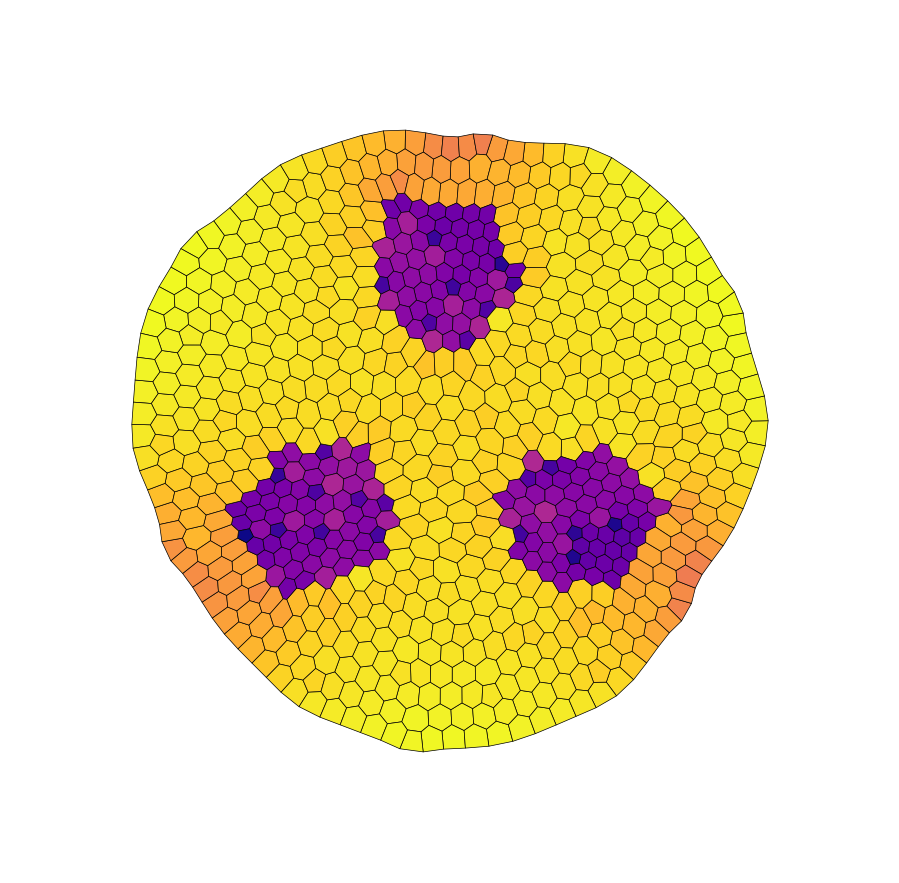

In [22]:
poly_verts = find_face_vertices_faster(tissue,tissue.face_dbonds)
# poly_verts_triang = find_face_vertices_faster(tissue_dual_triangulation,tissue_dual_triangulation.face_dbonds)


# facecolors = get_face_colors(tissue,color_by='num_sides')
fig, ax = plt.subplots(nrows = 1, ncols = 1, frameon = True, dpi=1000)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_frame_on(False)


# coll = PolyCollection(poly_verts, edgecolors='black',facecolors='mediumpurple',linewidths=0.1,zorder=1)
coll = PolyCollection(poly_verts, edgecolors='black',facecolors=facecolors,linewidths=0.05,zorder=1)

ax.add_collection(coll)


ax.autoscale_view()


side_size = 1.0
fig.set_size_inches(side_size, side_size)

# plt.clf()
plt.tight_layout()
plt.box(on=None)
plt.show()

fig.savefig('filename4.png',  transparent=True)

In [23]:
# tissue_triangulation = Triangulation(tissue,triangulation_type='subcellular_triangulation')

elong_tensor_per_cell = elongation_tensor_per_cell(tissue)
# twophi_per_cell = calculate_twophi(elong_tensor_per_cell)

# elong_lines_per_cell = elongation_lines_cells(tissue,twophi_per_cell,0.3)

In [24]:
patch_order = 3
contour_order = 1

neighbor_patch_per_cell = [g.neighborhood(cell_id, order=patch_order) for cell_id in g.vs['id']]

cells_inside_contour = [g.neighborhood(cell_id, order=contour_order) for cell_id in g.vs['id']]

contour_cells = \
        find_boundary_cells_of_patch(tissue,cells_inside_contour)
        
contour_cells = ordered_boundary_contour_per_patch(g,contour_cells)


In [26]:
elong_tensor_per_patch = coarse_grained_tensor(tissue,elong_tensor_per_cell,neighbor_patch_per_cell)

twophi_per_patch = calculate_twophi(elong_tensor_per_patch)

rotation_angle_around_patch = find_rotation_angle_contour(contour_cells,twophi_per_patch)



In [27]:
[np.min(rotation_angle_around_patch),np.max(rotation_angle_around_patch)]

[-0.5000000000000001, 0.5000000000000007]

In [28]:
elong_lines_per_patch = elongation_lines_cells(tissue,twophi_per_patch,0.3)

In [29]:
min_rot_angle = -0.5
max_rot_angle = 0.5#0.5

rot_angle_diff = max_rot_angle - min_rot_angle   

    
normalized_values = \
            (rotation_angle_around_patch - min_rot_angle)/ rot_angle_diff

# normalized_values = normalized_values

# facecolors = [cm.bwr(x) for x in normalized_values]
facecolors = [cm.coolwarm(x) for x in normalized_values]

In [30]:
cmap = plt.colormaps['plasma']

norm = plt.Normalize(min_area_strain, max_area_strain)

facecolors = [cmap(norm(x)) for x in area_strain]

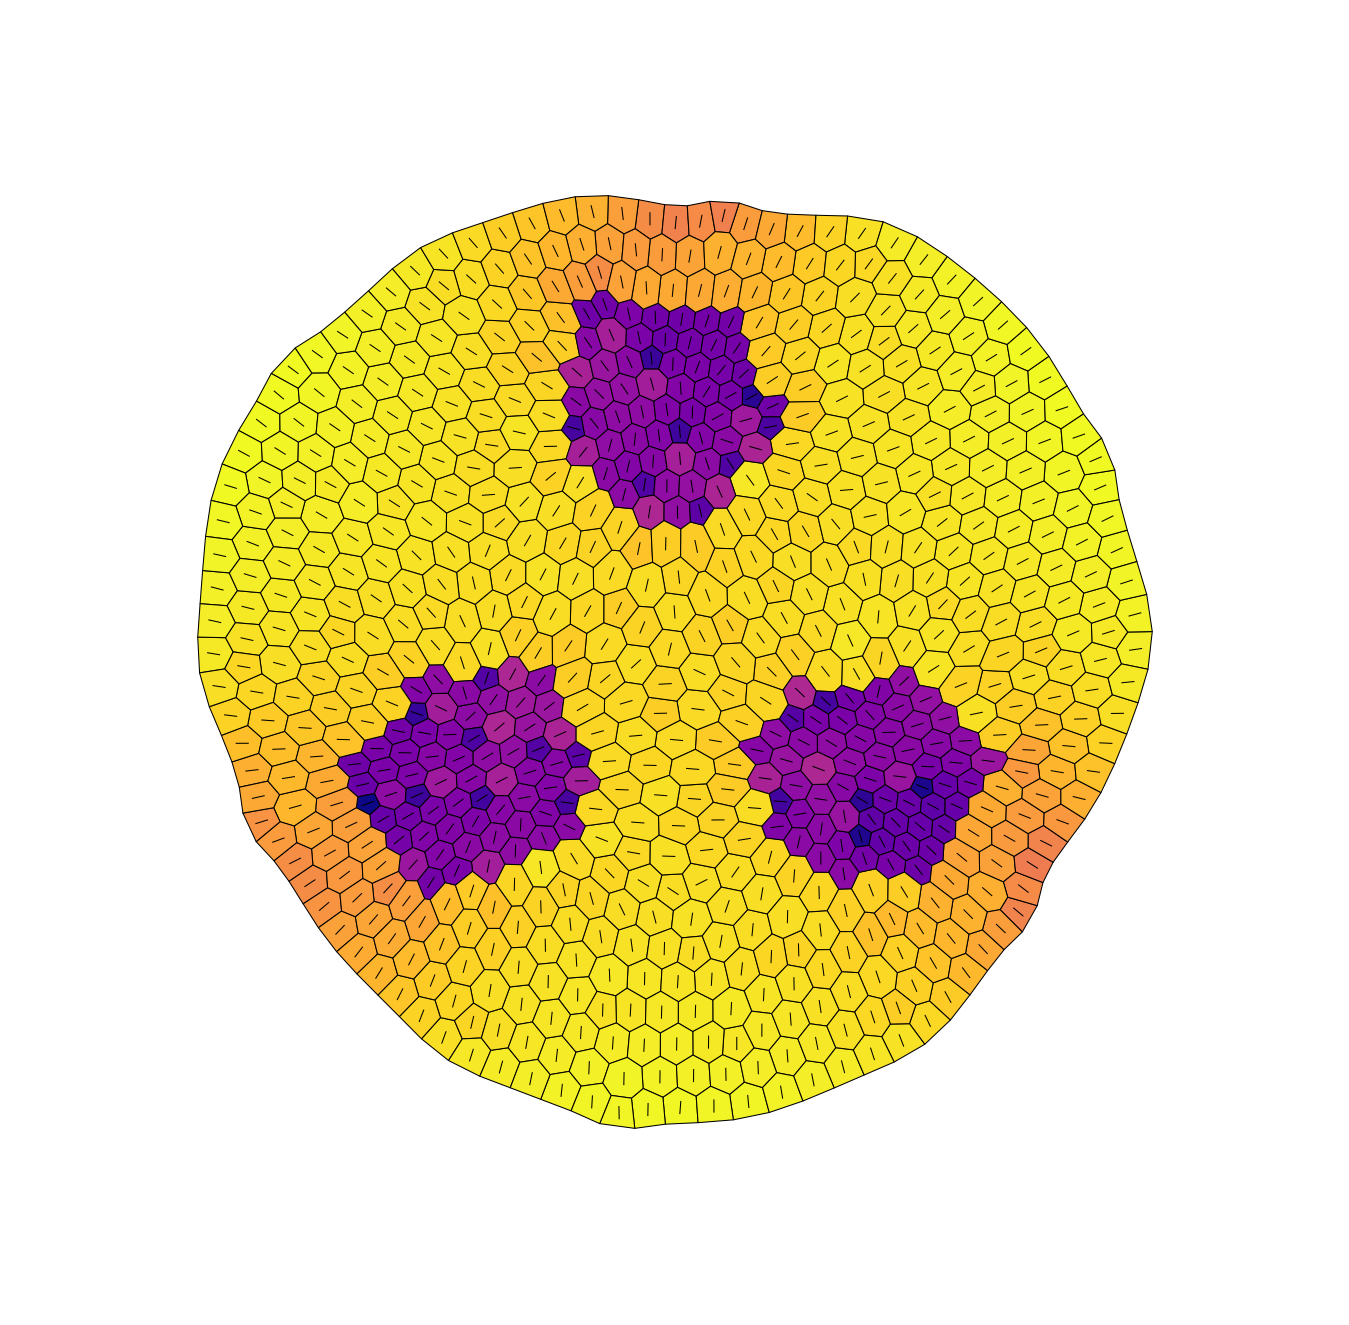

In [31]:
poly_verts = find_face_vertices_faster(tissue,tissue.face_dbonds)
# poly_verts_triang = find_face_vertices_faster(tissue_triangulation,tissue_triangulation.face_dbonds)

# facecolors = get_face_colors(tissue,color_by='num_sides')

# facecolors = get_face_colors(tissue,color_by='area',color_map=cm.plasma)
fig, ax = plt.subplots(nrows = 1, ncols = 1, frameon = True, dpi=1500)
ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_frame_on(False)


coll = PolyCollection(poly_verts, edgecolors='black',facecolors=facecolors,linewidths=0.05,zorder=1)

# coll = PolyCollection(poly_verts, edgecolors='black',facecolors='mediumpurple',linewidths=0.05,zorder=1)

# for neighbors in neighbor_list:
#     coll2 = PolyCollection(poly_verts[neighbors], edgecolors='black',facecolors='lightyellow',linewidths=0.1,
#                            alpha=0.4,zorder=2)
#     ax.add_collection(coll2)

# for neighbors in neighbor_list_centroid:
#     coll2 = PolyCollection(poly_verts[neighbors], edgecolors='black',facecolors='lightblue',linewidths=0.1,zorder=2)
#     ax.add_collection(coll2)
    

# coll2 = PolyCollection(poly_verts[neighbor_list], edgecolors='black',facecolors='red',linewidths=0.1,zorder=2)
# coll3 = PolyCollection(poly_verts[center_cell_ids], edgecolors='black',facecolors='green',linewidths=0.1,zorder=3)

# coll4 = PolyCollection(poly_verts_triang, edgecolors='black',facecolors='orange',linewidths=0.05,alpha=0.5,zorder=4)

# for neighbors in ordered_contours_per_patch:
#     coll4 = PolyCollection(poly_verts[neighbors], edgecolors='black',facecolors='salmon',linewidths=0.1,zorder=4)
#     ax.add_collection(coll4)

lc = LineCollection(elong_lines_per_patch, colors='black', linewidths=0.05,zorder=5)

ax.add_collection(coll)
ax.add_collection(lc)

ax.autoscale_view()


side_size = 1.0
fig.set_size_inches(side_size, side_size)

# plt.clf()
fig.tight_layout()
plt.box(on=None)
plt.show()

# fig.savefig('filename5.png',  transparent=True)

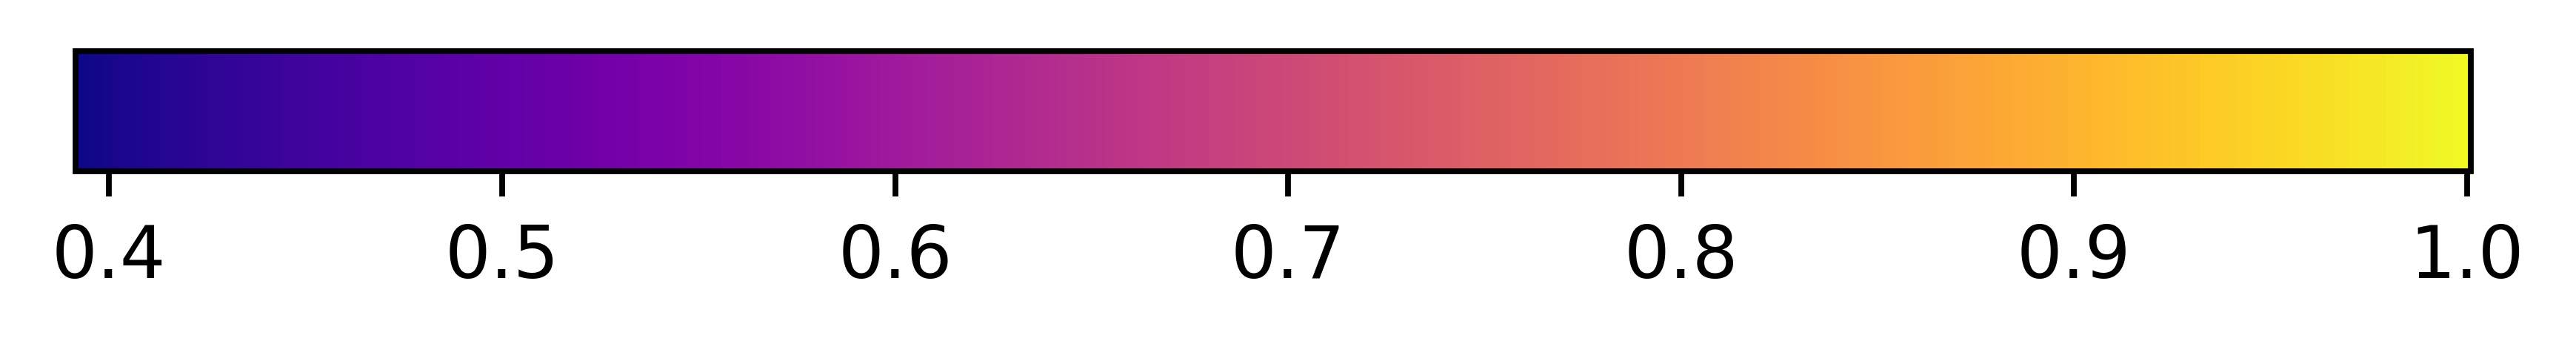

In [211]:
a = np.array([[min_area_strain,max_area_strain]])
plt.figure(figsize=(9, 2.),dpi=700)
img = plt.imshow(a, cmap="plasma")
plt.gca().set_visible(False)
# cax = plt.axes([0.1, 0.2, 0.8, 0.2])

# cax.tick_params(axis='both', which='major', labelsize=22)
plt.colorbar(orientation="horizontal")